# **Training of the teacher models used in FK-MTKD**.

These are the pretrained teacher models used to train the student model in the FK-MTKD algorithms.

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

2024-05-31 12:57:36.180365: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-31 12:57:36.210521: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 12:57:36.210545: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 12:57:36.210572: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 12:57:36.216502: I tensorflow/core/platform/cpu_feature_g

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [ ]:
import pandas as pd
import random
import cv2
#from keras.utils.vis_utils import plot_model
import os.path
from PIL import Image
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
import os
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
#import keras_tuner as kt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras
import logging
tf.config.set_visible_devices([], 'GPU')
from sklearn import preprocessing

# Set TensorFlow logging level to only display errors
tf.get_logger().setLevel(logging.ERROR)
## Imports libs
# from omnixai.data.image import Image
# from omnixai.preprocessing.image import Resize
# from omnixai.explainers.vision.specific.gradcam import GradCAM
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

from tqdm import tqdm
from tqdm.notebook import tqdm
import time

#import tensorflow_federated as tff
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tqdm import tqdm
import time

In [ ]:
### preprocessing or images

IMAGE_SIZE = 200
class ImageDataProcessor:
    def __init__(self):
        pass

    def process_image(self, folderpath, prefix, fileExtension, binary_label):
        folder_path = folderpath
        new_prefix = prefix

        img_names = []
        with os.scandir(folder_path) as dirs:
            for entry in dirs:
                img_names.append(entry.name)
        scaler = MinMaxScaler()
        all_features = []

        for img in img_names:
            path = folder_path + img
            cv_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            cv_img2 = cv2.resize(cv_img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            # Normalize pixel values
            normalized_img = cv_img2 / 255.0  # Scale pixel values to [0, 1]

            # Reshape the normalized image into a feature vector
            nFeatures = (normalized_img.shape[0] * normalized_img.shape[1])
            features = np.reshape(normalized_img, nFeatures)

            all_features.append(features)

        imgs_df = pd.DataFrame(np.array(all_features), index=img_names)
        if binary_label == 0:
            imgs_df['class_label'] = np.zeros((imgs_df.shape[0]), dtype=int)
        else:
            imgs_df['class_label'] = np.ones((imgs_df.shape[0]), dtype=int)
        return imgs_df

    def process_dataset(self, ct_covid_features_df, ct_noncovid_features_df, num_iterations=100):
        cvd_imgs = [ct_noncovid_features_df, ct_covid_features_df]
        cvd_imgs_dataset = pd.concat(cvd_imgs)

        for _ in range(num_iterations):
            cvd_imgs_dataset = cvd_imgs_dataset.sample(frac=1)

        input_data_x = cvd_imgs_dataset.iloc[:, :-1].to_numpy().reshape((cvd_imgs_dataset.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))

        label_encoder = preprocessing.LabelEncoder()
        cvd_imgs_dataset['output_encode'] = label_encoder.fit_transform(cvd_imgs_dataset['class_label'])
        cvd_imgs_dataset = pd.get_dummies(cvd_imgs_dataset, columns=['output_encode'])
        output_label_y = np.array(cvd_imgs_dataset[['output_encode_0', 'output_encode_1']])

        return input_data_x, output_label_y


## Data Source

Hopital 1 (Datasets 1), Hospital 2 (Dataset2 2) and Hospital 3 (Datasets 3)

- https://github.com/ieee8023/covid-chestxray-dataset/tree/master/images (dataset3)
- https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset/ (dataset3)

- https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset (dataset2)

- https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans (Dataset1)
- https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset (Dataset1)

### Loading preprocessed datasets saved as numpy array

In [ ]:
# # Load the array from the file
input_data_x_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset1_input.npy')
output_label_y_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset1_output.npy')
input_data_x_2_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset2_input.npy')
output_label_y_2_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset2_output.npy')
input_data_x_3_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset3_input.npy')#.astype('float64')
output_label_y_3_load = np.load('/home/rkannan/Desktop/2024 Projects/FedLearning_tensorflow_tutorial/COVID-19_FedKd_PR/moreImages_300/Dataset3_output.npy')
#input_da
# input_data_x_4_load = np.load('moreImages/Dataset4_input.npy')
# output_label_4_3_load = np.load('moreImages/Dataset4_output.npy')

# input_data_x_load = np.load('Dataset1_input.npy')
# output_label_y_load = np.load('Dataset1_output.npy')
# input_data_x_2_load = np.load('Dataset2_input.npy')
# output_label_y_2_load = np.load('Dataset2_output.npy')
# # input_data_x_3_load = np.load('Dataset3_input.npy')
# # output_label_y_3_load = np.load('Dataset3_output.npy')
# input_data_x_4_load = np.load('Dataset4_input.npy')
# output_label_y_4_load = np.load('Dataset4_output.npy')

# Now loaded_arr contains the array loaded from the file
print('------------------ DATASET 1 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_load.shape))

print('------------------ DATASET 2 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_2_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_2_load.shape))

print('------------------ DATASET 3 ---------------------')
print('Input_x Data Shape: \n{0}'.format(input_data_x_3_load.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y_3_load.shape))

# print('------------------ DATASET 4 ---------------------')
# print('Input_x Data Shape: \n{0}'.format(input_data_x_4_load.shape))
# print('Output_y Data Shape: \n{0}'.format(output_label_y_4_load.shape))

------------------ DATASET 1 ---------------------
Input_x Data Shape: 
(4649, 200, 200, 1)
Output_y Data Shape: 
(4649, 2)
------------------ DATASET 2 ---------------------
Input_x Data Shape: 
(14486, 200, 200, 1)
Output_y Data Shape: 
(14486, 2)
------------------ DATASET 3 ---------------------
Input_x Data Shape: 
(2540, 200, 200, 1)
Output_y Data Shape: 
(2540, 2)


### Training Teacher Models on Datasets to train student model in the federated learning context via multi knowledge distillation

In [ ]:
#len([i for i in output_label_y_load if i[0]==0])

##### teacher models Dataset and Federated Datsets

In [ ]:
from sklearn.model_selection import train_test_split


train_features_dataset1, test_features_dataset1, train_labels_dataset1, test_labels_dataset1 = train_test_split(
    input_data_x_load[0:2500,:], output_label_y_load[0:2500,:], test_size=.20, random_state=25)

train_features_dataset2, test_features_dataset2, train_labels_dataset2, test_labels_dataset2 = train_test_split(
    input_data_x_2_load[0:6500,:], output_label_y_2_load[0:6500,:], test_size=.20, random_state=25)

train_features_dataset3, test_features_dataset3, train_labels_dataset3, test_labels_dataset3 = train_test_split(
    input_data_x_3_load[0:1200,:], output_label_y_3_load[0:1200,:], test_size=.20, random_state=25)

print('------ Training Teacher Models----------')
print('client 1 teacher dataset: ',train_features_dataset1.shape, test_features_dataset1.shape, train_labels_dataset1.shape, test_labels_dataset1.shape)
print('client 2 teacher dataset: ',train_features_dataset2.shape, test_features_dataset2.shape, train_labels_dataset2.shape, test_labels_dataset2.shape)
print('client 3 teacher dataset: ',train_features_dataset3.shape, test_features_dataset3.shape, train_labels_dataset3.shape, test_labels_dataset3.shape)

------ Training Teacher Models----------
client 1 teacher dataset:  (2000, 200, 200, 1) (500, 200, 200, 1) (2000, 2) (500, 2)
client 2 teacher dataset:  (5200, 200, 200, 1) (1300, 200, 200, 1) (5200, 2) (1300, 2)
client 3 teacher dataset:  (960, 200, 200, 1) (240, 200, 200, 1) (960, 2) (240, 2)


##### Data Augmentation on Dataset to train Teacher Models

In [ ]:
from tensorflow import keras
image_size_ = 200
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size_, image_size_),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(train_features_dataset1)

### Functions to Evaluate Models after Training

In [ ]:
import seaborn as sns
def getCorrectLabel(x):
        if x == 0:
            return 'Non-Covid'
        if x == 1:
            return 'Covid'

def D1_to_D2(y_pred):
    y_true = {'y_true':[i[0] for i in y_pred]}
    y_true_df = pd.DataFrame(y_true)
    y_true_df = pd.get_dummies(y_true_df, columns =['y_true'])
    output_label_y = np.array(y_true_df[y_true_df.columns])
    return output_label_y

def getModelEvaluation(model, test_features_,test_labels_):
    predicted_labels = model.predict(np.stack(test_features_))
    df = pd.DataFrame(predicted_labels)
    df['Predicted_Labels'] = np.array(df.iloc[:,:2]).argmax(axis =1)
    df['Predicted_Labels'] = df['Predicted_Labels'].apply(getCorrectLabel)
    if (test_labels_.shape[1]==2):
        df['Actual_Labels'] = test_labels_[:,:2].argmax(axis = 1)
    else:
        df['Actual_Labels'] = D1_to_D2(test_labels_)[:,:2].argmax(axis = 1)
    df['Actual_Labels'] = df['Actual_Labels'].apply(getCorrectLabel)
    cm = pd.crosstab(df.Predicted_Labels, df.Actual_Labels)
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(121)
    sns.heatmap(cm,annot = True,cmap='Blues')
    ax1.set_title('')
    # Saving the figure.
    plt.savefig("test_Confusion_Matrix_with_i.jpg")
    plt.show()
    plt.close()

    test_labels__ = [i.argmax() for i in test_labels_]
    pred_list = [i.argmax() for i in predicted_labels]
    count = 0
    for i in range(test_labels_.shape[0]):
        if int(test_labels__[i]) == int(pred_list[i]):
            count+=1
    print("test accuracy = " + str((count/test_labels_.shape[0])*100)+'%')
    print('-------------------------------------------------------------------------------------------------')
    print('Model Metrics')
    # getting model predictions
    #test_predictions,_ = model.predict((x_test,y_test),20)
    predictions = pd.DataFrame(predicted_labels)#, columns=labels_ohe_names.columns
    predictions = list(predictions.idxmax(axis=1))
    test_labels__ = [i.argmax() for i in test_labels_]

    # evaluate model performance
    import model_evaluation_utils_ as meu
    meu.get_metrics(true_labels=test_labels__,
                    predicted_labels=predictions)

##### Training Teacher Model (CovidCNN)

In [ ]:
def CNN_Mod(model, num_hl, hl_list,hl_conv_activation, ol_activation, dropout_val, inputShape,filters_,kernel_size_,stride_poolSize):
    '''
    CNN_Mod(model, num_hl, hl_list,hl_conv_activation, ol_activation, dropout_val, inputShape,filters_,kernel_size_,stride_poolSize):
        model = CNN Model
        num_hl = number of hidden layers
        hl_list = list of hidden layers
        hl_activation = hidden layer activation function
        out_activation = output layer activation function
        dropout_val = Dropout value
        inputShape = shape of input layer
        filters_ = filter size of Conv layer
        kernel_size_ = size of kernel (x,x)
        strides_poolSize = strides and max_pool_szie
    '''
    assert(num_hl == len(hl_list))
    assert(num_hl == len(dropout_val))
    inputs = tf.keras.layers.Input(shape=inputShape)
    # Augment data.
    augmented = data_augmentation(inputs)
    initializer = tf.keras.initializers.GlorotNormal(seed=0)
    #connnnvolultion layer 1 with Map-pooling
    conv_layer_1 = tf.keras.layers.Conv2D(filters = filters_,kernel_size = kernel_size_,strides = stride_poolSize, activation = hl_conv_activation)(augmented)#(augmented)
    conv_layer_1_max_pool = tf.keras.layers.MaxPool2D(strides=stride_poolSize)(conv_layer_1)
    x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(conv_layer_1_max_pool)

    #connnnvolultion layer 1 with Map-pooling
    conv_layer_2 = tf.keras.layers.Conv2D(filters = filters_,kernel_size = kernel_size_,strides = stride_poolSize, activation = hl_conv_activation)(x1)
    conv_layer_2_max_pool = tf.keras.layers.MaxPool2D(strides=stride_poolSize)(conv_layer_2)
    x2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(conv_layer_2_max_pool)

    flatten_layer = tf.keras.layers.Flatten()(x2)

    dense_layers = tf.keras.layers.Dense(kernel_initializer=initializer, units = hl_list[0], activation = hl_conv_activation)(flatten_layer)
    dense_layers = tf.keras.layers.Dropout(dropout_val[0])(dense_layers)
    #dense_layers = tf.keras.layers.LayerNormalization()(dense_layers)           # Batch normalization layer

    dense_layers = tf.keras.layers.Dense(kernel_initializer=initializer, units = hl_list[1], activation = hl_conv_activation)(dense_layers)
    dense_layers = tf.keras.layers.Dropout(dropout_val[1])(dense_layers)
    #dense_layers = tf.keras.layers.LayerNormalization()(dense_layers)

    dense_layers = tf.keras.layers.Dense(kernel_initializer=initializer, units = hl_list[2], activation = hl_conv_activation)(dense_layers)
    dense_layers = tf.keras.layers.Dropout(dropout_val[2])(dense_layers)
    #dense_layers = tf.keras.layers.LayerNormalization()(dense_layers)

    dense_layers = tf.keras.layers.Dense(kernel_initializer=initializer, units = hl_list[3], activation = hl_conv_activation)(dense_layers)
    dense_layers = tf.keras.layers.Dropout(dropout_val[3])(dense_layers)
    #dense_layers = tf.keras.layers.LayerNormalization()(dense_layers)

    logits = tf.keras.layers.Dense(units = 2, activation = ol_activation)(dense_layers)

    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs,outputs=logits)
    model = compile_model(model, 'categorical_crossentropy',0.001,['accuracy'])#0621475226496656
    return model

def evaluateModel_loss(history):
    print()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['Training loss','Validation loss'], loc = 'upper left')
    plt.savefig("Training_validation_loss_with_i.jpg")
    plt.show()
    plt.close()
    #plt.show()
    print()
def evaluateModel_accuracy(history):
    print()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.legend(['Training Accuracy','Validation Accuracy'], loc = 'upper left')
    #plt.show()
    plt.savefig("Training_validation_accuracy_with_i.jpg")
    plt.show()
    plt.close()
    print()

def compile_model(model, loss_, learningRate, metrics_):
    '''
    def compile_model(DNN, loss_, learningRate, metrics_):
    DNN: the model
    loss_: the loss function
    learningRate: learning rate
    metrics_: metrics of interest [mse', 'mae'] #since a regression model
    '''
    model.compile(tf.keras.optimizers.Adam(learning_rate=learningRate),loss=loss_,metrics=metrics_)
    return model

def buildModel(model, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
  '''
  def buildModel(DNN, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
    DNN: DNN which the model
    val_split_size: the validation split)
    batch_size_: batch_size
    numEpochs: number of epochs
    patience_: patience of call back
    monitor_: monitor (objective of callback)
    mode: mode (min, max, auto)
  '''
  history = model.fit(
    train_features_dataset1,
    train_labels_dataset1,
    validation_split = val_split_size,
    batch_size = batch_size_,
    epochs = numEpochs,
    callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor= monitor_,patience=patience_,verbose=1,mode=mode),#monitoring loss mode should be min [---val_acc--]
    ]
    )

  return history

In [ ]:
teacher_model  = tf.keras.models.Sequential()
teacher_model  = CNN_Mod(teacher_model, 4, [362, 184, 78, 12],'relu','softmax',[0.00,0.35,0.0,0.00],(IMAGE_SIZE,IMAGE_SIZE,1),116,8,2)
history = buildModel(teacher_model,0.20,32,150,10, "val_loss", "min")
# # Load the Keras model
# teacher_model  = tf.keras.models.Sequential()
# teacher_model  = CNN_Mod(teacher_model, 4, [2756, 1776, 620, 152],'relu','softmax',[0.35,0.00,0.00,0.35],(IMAGE_SIZE,IMAGE_SIZE,1),214,5,3)
# history = buildModel(teacher_model,0.20,128,150,10, "val_loss", "min")

Epoch 1/150
50/50 [==============================] - 11s 204ms/step - loss: 0.6632 - accuracy: 0.6600 - val_loss: 0.5871 - val_accuracy: 0.6675
Epoch 2/150
50/50 [==============================] - 10s 200ms/step - loss: 0.5713 - accuracy: 0.7013 - val_loss: 0.5511 - val_accuracy: 0.7450
Epoch 3/150
50/50 [==============================] - 10s 202ms/step - loss: 0.5215 - accuracy: 0.7394 - val_loss: 0.5062 - val_accuracy: 0.7450
Epoch 4/150
50/50 [==============================] - 10s 201ms/step - loss: 0.4876 - accuracy: 0.7744 - val_loss: 0.4800 - val_accuracy: 0.7775
Epoch 5/150
50/50 [==============================] - 10s 201ms/step - loss: 0.4998 - accuracy: 0.7681 - val_loss: 0.4992 - val_accuracy: 0.7350
Epoch 6/150
50/50 [==============================] - 10s 200ms/step - loss: 0.4873 - accuracy: 0.7756 - val_loss: 0.4777 - val_accuracy: 0.7675
Epoch 7/150
50/50 [==============================] - 10s 201ms/step - loss: 0.4667 - accuracy: 0.7788 - val_loss: 0.4694 - val_accuracy:

50/50 [==============================] - 10s 201ms/step - loss: 0.0797 - accuracy: 0.9737 - val_loss: 0.2204 - val_accuracy: 0.9350
Epoch 58/150
50/50 [==============================] - 10s 202ms/step - loss: 0.0880 - accuracy: 0.9644 - val_loss: 0.2274 - val_accuracy: 0.9350
Epoch 58: early stopping


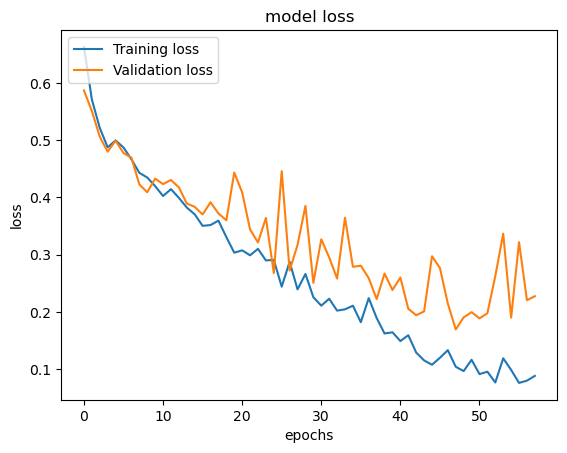

In [ ]:
evaluateModel_loss(history)

In [ ]:
teacher_model.save('teacher_CNN_model.h5')
teacher_model_cnn = tf.keras.models.load_model('teacher_CNN_model.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


--------------------- Teacher Model Evaluation -----------------------------------------
16/16 [==============================] - 1s 66ms/step


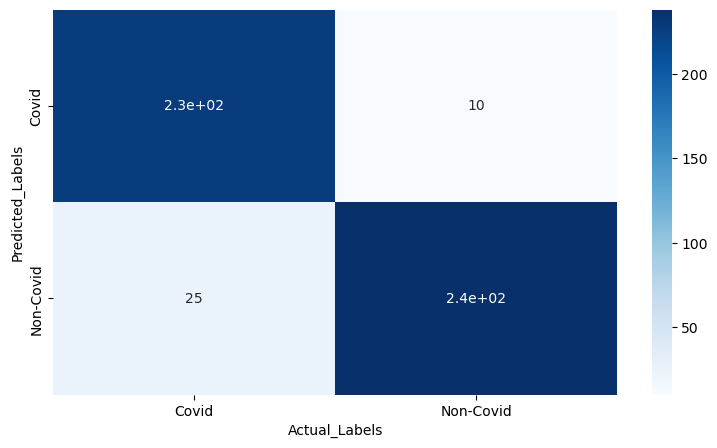

test accuracy = 93.0%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.93
Precision: 0.9316
Recall: 0.93
F1 Score: 0.93


In [ ]:
print('--------------------- Teacher Model Evaluation -----------------------------------------')
getModelEvaluation(teacher_model_cnn,test_features_dataset1,test_labels_dataset1)

#### Training the COVID-CNN model on dataset2 as a Teacher model

Epoch 1/100


2024-05-31 12:58:03.208920: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f4c04061110 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-05-31 12:58:03.208961: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-05-31 12:58:03.246804: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-31 12:58:03.418490: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-05-31 12:58:03.421094: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 12:58:03.513883: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 1/33 [..............................] - ETA: 1:11 - loss: 0.7898 - accuracy: 0.4766

2024-05-31 12:58:04.183159: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 12:58:04.186457: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 12:58:04.186657: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


14/33 [===========>..................] - ETA: 13s - loss: 0.8286 - accuracy: 0.5965

2024-05-31 12:58:13.454979: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


33/33 [==============================] - 27s 773ms/step - loss: 0.7174 - accuracy: 0.6685 - val_loss: 0.5594 - val_accuracy: 0.7587
Epoch 2/100
33/33 [==============================] - 25s 763ms/step - loss: 0.5189 - accuracy: 0.7837 - val_loss: 0.5144 - val_accuracy: 0.7788
Epoch 3/100
33/33 [==============================] - 25s 756ms/step - loss: 0.4823 - accuracy: 0.7995 - val_loss: 0.4940 - val_accuracy: 0.7837
Epoch 4/100
33/33 [==============================] - 25s 759ms/step - loss: 0.4824 - accuracy: 0.8007 - val_loss: 0.4977 - val_accuracy: 0.7875
Epoch 5/100
33/33 [==============================] - 25s 756ms/step - loss: 0.4896 - accuracy: 0.7988 - val_loss: 0.4945 - val_accuracy: 0.7865
Epoch 6/100
33/33 [==============================] - 25s 757ms/step - loss: 0.4637 - accuracy: 0.8070 - val_loss: 0.4971 - val_accuracy: 0.7913
Epoch 7/100
33/33 [==============================] - 25s 762ms/step - loss: 0.4659 - accuracy: 0.8046 - val_loss: 0.4776 - val_accuracy: 0.7875
Epoc

33/33 [==============================] - 25s 755ms/step - loss: 0.1288 - accuracy: 0.9466 - val_loss: 0.2144 - val_accuracy: 0.9231
Epoch 58/100
33/33 [==============================] - 25s 755ms/step - loss: 0.1090 - accuracy: 0.9572 - val_loss: 0.2038 - val_accuracy: 0.9260
Epoch 59/100
33/33 [==============================] - 25s 760ms/step - loss: 0.1076 - accuracy: 0.9572 - val_loss: 0.2448 - val_accuracy: 0.9308
Epoch 60/100
33/33 [==============================] - 25s 759ms/step - loss: 0.1137 - accuracy: 0.9553 - val_loss: 0.2359 - val_accuracy: 0.9240
Epoch 61/100
33/33 [==============================] - 25s 758ms/step - loss: 0.1158 - accuracy: 0.9548 - val_loss: 0.1995 - val_accuracy: 0.9288
Epoch 62/100
33/33 [==============================] - 25s 756ms/step - loss: 0.1075 - accuracy: 0.9584 - val_loss: 0.2721 - val_accuracy: 0.9048
Epoch 63/100
33/33 [==============================] - 25s 757ms/step - loss: 0.1150 - accuracy: 0.9565 - val_loss: 0.2279 - val_accuracy: 0.914

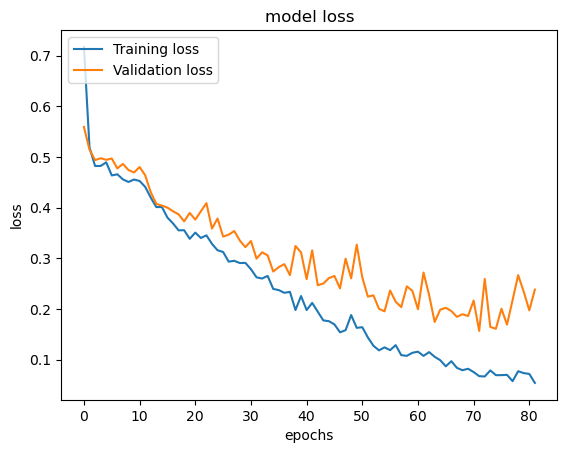

In [ ]:
def buildModel_dataset2(model, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
  '''
  def buildModel(DNN, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
    DNN: DNN which the model
    val_split_size: the validation split)
    batch_size_: batch_size
    numEpochs: number of epochs
    patience_: patience of call back
    monitor_: monitor (objective of callback)
    mode: mode (min, max, auto)
  '''
  history = model.fit(
    train_features_dataset2,
    train_labels_dataset2,
    validation_split = val_split_size,
    batch_size = batch_size_,
    epochs = numEpochs,
    callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor= monitor_,patience=patience_,verbose=1,mode=mode),#monitoring loss mode should be min [---val_acc--]
    ]
    )

  return history

teacher_model_dataset2  = tf.keras.models.Sequential()
teacher_model_dataset2  = CNN_Mod(teacher_model_dataset2, 4, [362, 184, 78, 12],'relu','softmax',[0.00,0.35,0.0,0.00],(IMAGE_SIZE,IMAGE_SIZE,1),116,8,2)
history_dataset2 = buildModel_dataset2(teacher_model_dataset2,0.20,128,100,10, "val_loss", "min")
evaluateModel_loss(history_dataset2)

--------------------- Teacher Model Evaluation -----------------------------------------
41/41 [==============================] - 3s 67ms/step


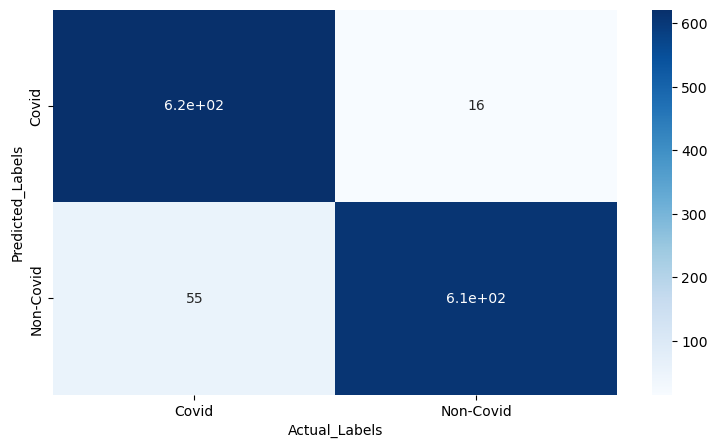

test accuracy = 94.53846153846153%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.9454
Precision: 0.9471
Recall: 0.9454
F1 Score: 0.9454


In [ ]:
print('--------------------- Teacher Model Evaluation -----------------------------------------')
getModelEvaluation(teacher_model_dataset2,test_features_dataset2,test_labels_dataset2)

In [ ]:
teacher_model_dataset2.save('teacher_CNN_model_dataset2.h5')
teacher_model_dataset2 = tf.keras.models.load_model('teacher_CNN_model_dataset2.h5')

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Training Teacher Model (Deep-COVID)
M. Ghaderzadeh, F. Asadi, R. Jafari, D. Bashash, H. Abolghasemi, and M. Aria. Deep
convolutional neural network–based computer-aided detection system for covid-19 using mul-
tiple lung scans: Design and implementation study. J Med Internet Res, 23:e27468, 2021,4.
http://www.ncbi.nlm.nih.gov/pubmed/33848973


In [ ]:
import os
import random
import numpy as np
import math
import itertools

SEED = 7
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)
import tensorflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras.backend as K

from tensorflow.keras.applications import NASNetLarge
NETWORK = NASNetLarge

#from kaggle_datasets import KaggleDatasets

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report


import re
import imageio
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
try:
    tpu = None
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print("Tensorflow version ", tf.__version__)


Number of replicas: 1
Tensorflow version  2.14.0


In [ ]:
from tensorflow.keras.callbacks import Callback
class CosineAnnealingScheduler(Callback):

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

image_size = 200
img_augmentation = keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size, image_size),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="Augmentation",
)
img_augmentation.layers[0].adapt(train_features_dataset1)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.config.optimizer.set_jit(True)

# dataset_id1 = 'covid19-lung-ct-scans'
# #GCS_PATH1 = KaggleDatasets().get_gcs_path(dataset_id1)
BATCH_SIZE = 128 * strategy.num_replicas_in_sync

CLASSES = ['COVID-19', 'Non-COVID-19']
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE_ = [IMAGE_SIZE, IMAGE_SIZE]#224, 224
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 1)#224, 224, 3
LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

METRICS = ['accuracy']

Epochs = 50
Early_Stop = 15
OPTIMIZER = tensorflow.keras.optimizers.legacy.Adam(lr = 1e-2, decay = 1e-4)

Fine_Tune_Epochs = 100
Fine_Tune_Early_Stop = 20
Fine_Tune_OPTIMIZER = tensorflow.keras.optimizers.legacy.Adam(lr = 1e-3, decay = 1e-6)
Fine_Tune_filepath = "Best-Model-FT.h5"

Callbacks = [
    CosineAnnealingScheduler(Epochs, 1e-3, 1e-6),
    EarlyStopping(monitor='val_accuracy', patience=Early_Stop, mode='auto', min_delta=0.00001, verbose=2, restore_best_weights=True)]

FT_Callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=2, mode='min', min_delta=0.0001, cooldown=1, min_lr=1e-6),
    ModelCheckpoint(Fine_Tune_filepath, monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=False, mode='max'),
    EarlyStopping(monitor='val_loss', patience=Fine_Tune_Early_Stop, mode='auto', min_delta=0.00001, verbose=2, restore_best_weights=True)]

from tensorflow.keras.layers import Lambda
input_tensor = Input(shape=input_shape)
input_rgb = Lambda(lambda x: K.repeat_elements(x, 3, axis=-1))(input_tensor)

def build_model(OPTIMIZER, LOSS, METRICS):
    model = None
    inputs = layers.Input(shape=input_shape)
    x = img_augmentation(inputs)
    baseModel = keras.applications.NASNetLarge(
    #input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    input_tensor=input_rgb,
    pooling='avg',
    classifier_activation="softmax",
)
    #baseModel = NETWORK(include_top=False, input_tensor=x, weights="imagenet", pooling ='avg')

    baseModel.trainable = False

    x = BatchNormalization(axis = -1, name="Batch-Normalization-1")(baseModel.output)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization(axis = -1, name="Batch-Normalization-2")(x)
    x = Dropout(.2, name="Dropout-1")(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization(axis = -1, name="Batch-Normalization-3")(x)

    outputs = Dense(NUM_CLASSES, activation="softmax", name="Classifier")(x)
    model = tf.keras.Model(inputs=baseModel.input, outputs=outputs, name="Deep-COVID")

    model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

    return model

Deep_COVID_Model_teacher = build_model(OPTIMIZER, LOSS, METRICS)

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
def fit_model(model,Epochs, Callbacks, class_weight=None):
    history = model.fit(
        train_features_dataset2,
        train_labels_dataset2,
        validation_split = 0.2,
        epochs=Epochs,
        callbacks=Callbacks,
        verbose=2,
    )
    return history

history_Deep_COVID = fit_model(Deep_COVID_Model_teacher, Epochs, Callbacks)

Epoch 1/50
130/130 - 131s - loss: 1.0493 - accuracy: 0.8322 - val_loss: 1.0110 - val_accuracy: 0.7817 - lr: 0.0010 - 131s/epoch - 1s/step
Epoch 2/50
130/130 - 116s - loss: 0.8942 - accuracy: 0.9007 - val_loss: 0.8971 - val_accuracy: 0.8683 - lr: 9.9901e-04 - 116s/epoch - 894ms/step
Epoch 3/50
130/130 - 116s - loss: 0.8371 - accuracy: 0.9082 - val_loss: 0.8478 - val_accuracy: 0.8760 - lr: 9.9606e-04 - 116s/epoch - 893ms/step
Epoch 4/50
130/130 - 118s - loss: 0.7756 - accuracy: 0.9255 - val_loss: 0.7900 - val_accuracy: 0.8837 - lr: 9.9115e-04 - 118s/epoch - 904ms/step
Epoch 5/50
130/130 - 115s - loss: 0.7160 - accuracy: 0.9382 - val_loss: 0.7491 - val_accuracy: 0.8942 - lr: 9.8431e-04 - 115s/epoch - 886ms/step
Epoch 6/50
130/130 - 115s - loss: 0.6776 - accuracy: 0.9428 - val_loss: 0.7273 - val_accuracy: 0.8923 - lr: 9.7555e-04 - 115s/epoch - 885ms/step
Epoch 7/50
130/130 - 115s - loss: 0.6366 - accuracy: 0.9510 - val_loss: 0.6781 - val_accuracy: 0.8971 - lr: 9.6492e-04 - 115s/epoch - 885

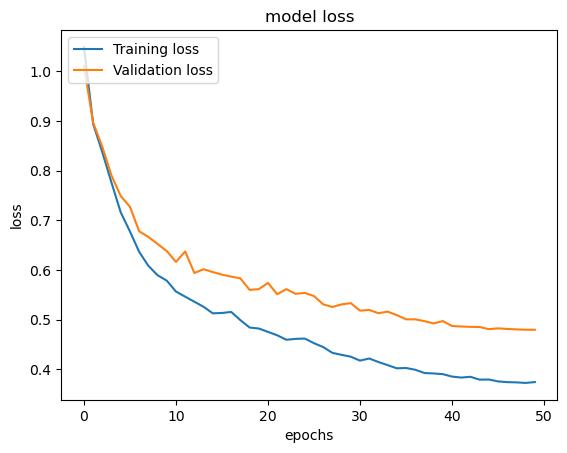

In [ ]:
evaluateModel_loss(history_Deep_COVID)

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


--------------------- Teacher Model Evaluation -----------------------------------------
41/41 [==============================] - 32s 701ms/step


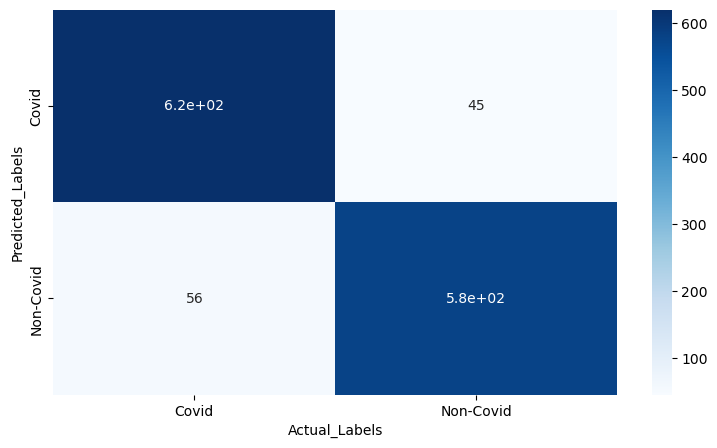

test accuracy = 92.23076923076923%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.9223
Precision: 0.9225
Recall: 0.9223
F1 Score: 0.9223


In [ ]:
Deep_COVID_Model_teacher.save('Deep_COVID_teacher_model.h5')
Deep_COVID_Model_teacher = tf.keras.models.load_model('Deep_COVID_teacher_model.h5')
print('--------------------- Teacher Model Evaluation -----------------------------------------')
getModelEvaluation(Deep_COVID_Model_teacher,test_features_dataset2,test_labels_dataset2)

#### Training the DeepCovid model on dataset1 as a Teacher model

In [ ]:
def fit_model(model,Epochs, Callbacks, class_weight=None):
    history = model.fit(
        train_features_dataset1,
        train_labels_dataset1,
        validation_split = 0.2,
        epochs=Epochs,
        callbacks=Callbacks,
        verbose=2,
    )
    return history

history_Deep_COVID_dataset1 = fit_model(Deep_COVID_Model_teacher_dataset1, Epochs, Callbacks)
evaluateModel_loss(history_Deep_COVID_dataset1)
Deep_COVID_Model_teacher_dataset1.save('Deep_COVID_teacher_model_dataset1.h5')
Deep_COVID_Model_teacher_dataset1 = tf.keras.models.load_model('Deep_COVID_teacher_model_dataset1.h5')
print('--------------------- Teacher Model Evaluation -----------------------------------------')
getModelEvaluation(Deep_COVID_Model_teacher_dataset1,test_features_dataset1,test_labels_dataset1)

#### Running the DeepCovid model on dataset3 as a Teacher model

In [ ]:
def fit_model(model,Epochs, Callbacks, class_weight=None):
    history = model.fit(
        train_features_dataset3,
        train_labels_dataset3,
        validation_split = 0.2,
        epochs=Epochs,
        callbacks=Callbacks,
        verbose=2,
    )
    return history

history_Deep_COVID_dataset3 = fit_model(Deep_COVID_Model_teacher_dataset3, Epochs, Callbacks)
evaluateModel_loss(history_Deep_COVID_dataset3)
Deep_COVID_Model_teacher_dataset3.save('Deep_COVID_teacher_model_dataset3.h5')
Deep_COVID_Model_teacher_dataset3 = tf.keras.models.load_model('Deep_COVID_teacher_model_dataset3.h5')
print('--------------------- Teacher Model Evaluation -----------------------------------------')
getModelEvaluation(Deep_COVID_Model_teacher_dataset3,test_features_dataset3,test_labels_dataset3)

### Covid-VGG16 teacher Model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Lambda
input_tensor = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1))
input_rgb = Lambda(lambda x: K.repeat_elements(x, 3, axis=-1))(input_tensor)

image_size_ = 200
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size_, image_size_),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

def CNN_Mod_VGG16(num_hl, hl_list, hl_conv_activation, ol_activation, dropout_val, inputShape, filters_, kernel_size_, stride_poolSize):
    '''
    CNN_Mod(num_hl, hl_list, hl_conv_activation, ol_activation, dropout_val, inputShape, filters_, kernel_size_, stride_poolSize):
        num_hl = number of hidden layers
        hl_list = list of hidden layer units
        hl_activation = hidden layer activation function
        out_activation = output layer activation function
        dropout_val = Dropout value
        inputShape = shape of input layer
        filters_ = filter size of Conv layer
        kernel_size_ = size of kernel (x,x)
        strides_poolSize = strides and max_pool_szie
    '''
    assert num_hl == len(hl_list)
    assert num_hl == len(dropout_val)

    inputs = tf.keras.layers.Input(shape=inputShape)
    # Augment data.
    augmented = data_augmentation(inputs)

    # Load EfficientNet as base model
    base_model = VGG16(include_top=False, input_tensor=input_rgb, weights='imagenet')

    # Freeze the base model
    base_model.trainable = False

    # Add custom head
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    for i in range(num_hl):
        x = tf.keras.layers.Dense(units=hl_list[i], activation=hl_conv_activation)(x)
        x = tf.keras.layers.Dropout(dropout_val[i])(x)

    # Output layer
    logits = tf.keras.layers.Dense(units=2, activation=ol_activation)(x)

    # Create the Keras model
    model = tf.keras.Model(inputs=base_model.input, outputs=logits)

    # Compile the model
    model = compile_model(model, 'categorical_crossentropy', 0.001, ['accuracy'])

    return model

def buildModel(model, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
  '''
  def buildModel(DNN, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
    DNN: DNN which the model
    val_split_size: the validation split)
    batch_size_: batch_size
    numEpochs: number of epochs
    patience_: patience of call back
    monitor_: monitor (objective of callback)
    mode: mode (min, max, auto)
  '''
  history = model.fit(
    train_features_dataset3,
    train_labels_dataset3,
    validation_split = val_split_size,
    batch_size = batch_size_,
    epochs = numEpochs,
    callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor= monitor_,patience=patience_,verbose=1,mode=mode),#monitoring loss mode should be min [---val_acc--]
    ]
    )

  return history



In [ ]:
# teacher_model  = tf.keras.models.Sequential()
# teacher_model  = CNN_Mod(teacher_model, 4, [2756, 1776, 620, 152],'relu','softmax',[0.35,0.00,0.00,0.35],(IMAGE_SIZE,IMAGE_SIZE,1),214,5,3)
# history = buildModel(teacher_model,0.20,128,150,10, "val_loss", "min")

In [ ]:
CNN_Mod_VGG16_teacher_model  = CNN_Mod_VGG16( 4, [2756, 1776, 620, 152],'relu','softmax',[0.65,0.00,0.00,0.65],(IMAGE_SIZE,IMAGE_SIZE,1),214,5,3)
CNN_Mod_VGG16_history = buildModel(CNN_Mod_VGG16_teacher_model,0.20,32,100,10, "val_loss", "min")

Epoch 1/100
24/24 [==============================] - 15s 605ms/step - loss: 0.9099 - accuracy: 0.4714 - val_loss: 0.6948 - val_accuracy: 0.5052
Epoch 2/100
24/24 [==============================] - 14s 598ms/step - loss: 0.6900 - accuracy: 0.5482 - val_loss: 0.6733 - val_accuracy: 0.6042
Epoch 3/100
24/24 [==============================] - 14s 597ms/step - loss: 0.6619 - accuracy: 0.6029 - val_loss: 0.6101 - val_accuracy: 0.7292
Epoch 4/100
24/24 [==============================] - 14s 598ms/step - loss: 0.6390 - accuracy: 0.6471 - val_loss: 0.5922 - val_accuracy: 0.7031
Epoch 5/100
24/24 [==============================] - 14s 599ms/step - loss: 0.5738 - accuracy: 0.7122 - val_loss: 0.5271 - val_accuracy: 0.6979
Epoch 6/100
24/24 [==============================] - 14s 600ms/step - loss: 0.5043 - accuracy: 0.7643 - val_loss: 0.5143 - val_accuracy: 0.7240
Epoch 7/100
24/24 [==============================] - 15s 610ms/step - loss: 0.5066 - accuracy: 0.7513 - val_loss: 0.4999 - val_accuracy:

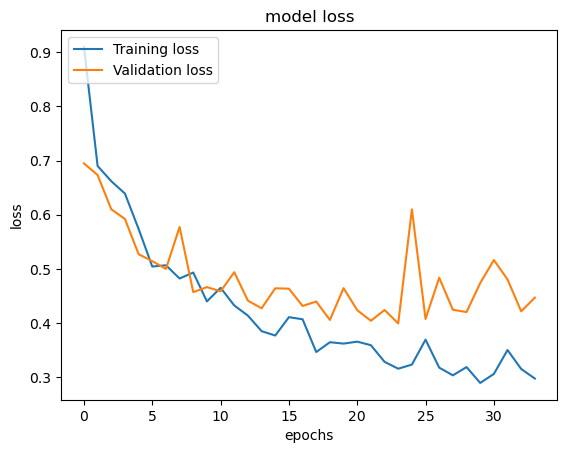

In [ ]:
evaluateModel_loss(CNN_Mod_VGG16_history)

/home/rkannan/miniconda3/envs/richard_tf_fedLearning/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


--------------------- Teacher Model Evaluation -----------------------------------------
8/8 [==============================] - 4s 425ms/step


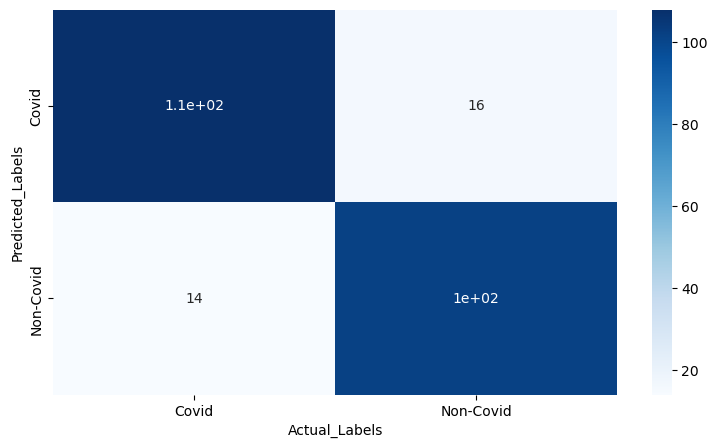

test accuracy = 87.5%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.875
Precision: 0.8751
Recall: 0.875
F1 Score: 0.875


In [ ]:
CNN_Mod_VGG16_teacher_model.save('CNN_Mod_VGG16_teacher_model.h5')
CNN_Mod_VGG16_teacher_model = tf.keras.models.load_model('CNN_Mod_VGG16_teacher_model.h5')
#DCD_Model_teacher.save_weights('DCD_teacher_model_weigth.h5')
print('--------------------- Teacher Model Evaluation -----------------------------------------')
getModelEvaluation(CNN_Mod_VGG16_teacher_model,test_features_dataset3,test_labels_dataset3)

#### Training the COVIDVGG16 model on dataset2 as a Teacher model

Epoch 1/100
33/33 [==============================] - 77s 2s/step - loss: 0.6686 - accuracy: 0.6387 - val_loss: 0.4471 - val_accuracy: 0.8000
Epoch 2/100
33/33 [==============================] - 78s 2s/step - loss: 0.4474 - accuracy: 0.8149 - val_loss: 0.3743 - val_accuracy: 0.8471
Epoch 3/100
33/33 [==============================] - 78s 2s/step - loss: 0.3860 - accuracy: 0.8440 - val_loss: 0.3444 - val_accuracy: 0.8625
Epoch 4/100
33/33 [==============================] - 78s 2s/step - loss: 0.3645 - accuracy: 0.8555 - val_loss: 0.3309 - val_accuracy: 0.8654
Epoch 5/100
33/33 [==============================] - 76s 2s/step - loss: 0.3562 - accuracy: 0.8582 - val_loss: 0.3403 - val_accuracy: 0.8606
Epoch 6/100
33/33 [==============================] - 75s 2s/step - loss: 0.3391 - accuracy: 0.8697 - val_loss: 0.3226 - val_accuracy: 0.8712
Epoch 7/100
33/33 [==============================] - 75s 2s/step - loss: 0.3399 - accuracy: 0.8678 - val_loss: 0.3358 - val_accuracy: 0.8673
Epoch 8/100
3

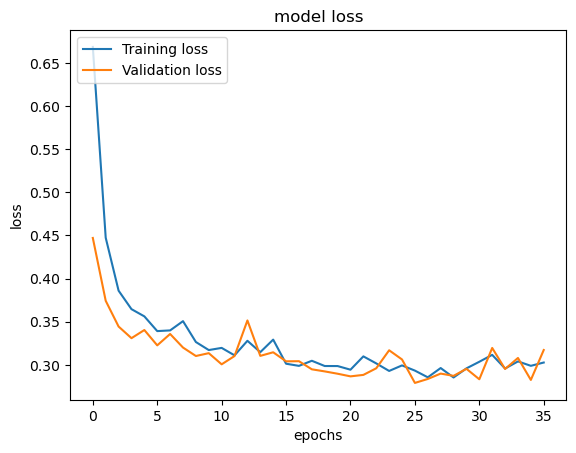

In [ ]:
def buildModel_iid(model, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
  '''
  def buildModel(DNN, val_split_size, batch_size_,numEpochs, patience_, monitor_, mode):
    DNN: DNN which the model
    val_split_size: the validation split)
    batch_size_: batch_size
    numEpochs: number of epochs
    patience_: patience of call back
    monitor_: monitor (objective of callback)
    mode: mode (min, max, auto)
  '''
  history = model.fit(
    train_features_dataset2,
    train_labels_dataset2,
    validation_split = val_split_size,
    batch_size = batch_size_,
    epochs = numEpochs,
    callbacks = [
      tf.keras.callbacks.EarlyStopping(monitor= monitor_,patience=patience_,verbose=1,mode=mode),#monitoring loss mode should be min [---val_acc--]
    ]
    )

  return history

CNN_Mod_VGG16_teacher_model_dataset2 = CNN_Mod_VGG16( 4, [2756, 1776, 620, 152],'relu','softmax',[0.65,0.00,0.00,0.65],(IMAGE_SIZE,IMAGE_SIZE,1),214,5,3)
CNN_Mod_VGG16_history_dataset2 = buildModel_iid(CNN_Mod_VGG16_teacher_model_datasdataset2,0.20,128,100,10, "val_loss", "min")
evaluateModel_loss(CNN_Mod_VGG16_history_dataset2)

--------------------- Teacher Model Evaluation -----------------------------------------
41/41 [==============================] - 19s 463ms/step


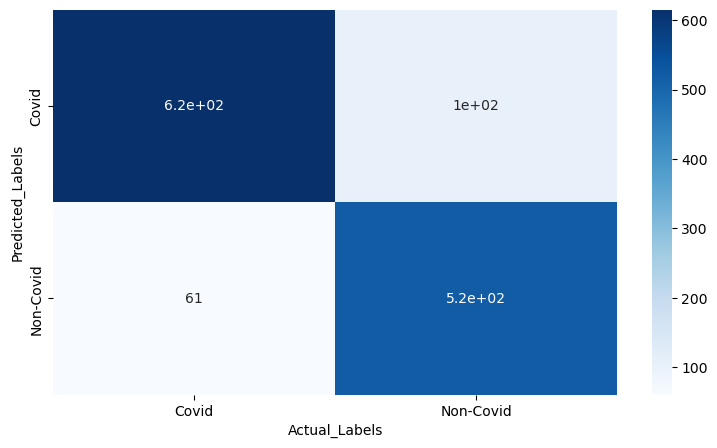

test accuracy = 87.38461538461539%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.8738
Precision: 0.8751
Recall: 0.8738
F1 Score: 0.8735


In [ ]:
#CNN_Mod_VGG16_teacher_model_dataset2.save('CNN_Mod_VGG16_teacher_model_dataset2.h5')
CNN_Mod_VGG16_teacher_model_dataset2 = tf.keras.models.load_model('CNN_Mod_VGG16_teacher_model_dataset2.h5')
print('--------------------- Teacher Model Evaluation -----------------------------------------')
getModelEvaluation(CNN_Mod_VGG16_teacher_model_dataset2,test_features_dataset2,test_labels_dataset2)